In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from agent import Agent, Env
from pfilter import ParticleFilter

In [2]:
im_x = 50
im_y = 50

seqlen = 200

In [3]:
env = Env(*[Agent(im_x, im_y) for _ in range(1)])

In [4]:
aa = env.step()[0]

In [5]:
aa

array([ 16.27010771,  35.04486867,  23.06613404,  40.97656509])

In [6]:
def evol_model(particles):
    particles = particles.copy()
    
    xy, wh = particles[:,:2], particles[:,2:4]
    vel = particles[:,4:]
    
    vel += np.random.normal(size=vel.shape)/4
    vel = np.clip(vel, -1, 1)
    
    xy += vel
    
    wh += np.random.normal(size=wh.shape)/20
    wh = np.clip(wh, 1, 30)
    
    xy = np.clip(xy, 0, np.array([im_x, im_y], dtype='float64') - wh)
    
    new_particles = np.concatenate([xy, wh, vel], axis=-1)
    return new_particles

def observe_model(particles, observe):
    xy, wh = particles[:,:2], particles[:,2:4]
    
    xyxy = np.concatenate([xy, xy + wh], axis=-1)
    
    whs = np.stack([wh,wh], axis=-1).reshape((-1,4))
    logd = - (xyxy - observe)**2/(2*(whs/8)**2) - np.log(np.sqrt(2*np.pi)*whs)
    logd = np.sum(logd, axis=-1)
    return logd

In [7]:
filt = ParticleFilter(20000, 4 + 2, evol_model, observe_model, resample_2entropy=0.7)

In [8]:
aa = env.step()[0]
filt.particles[:, :2] = aa[:2] + np.random.normal(size=filt.particles[:, :2].shape)*2
filt.particles[:, 2:4] = np.clip(1 + np.random.normal(size=filt.particles[:, 2:4].shape)*7, 0.5, 100)

In [9]:
observe = []
true = []
for _ in range(seqlen):
    observe.append(env.step()[0])
    true.append(env.agents[0].pos)
    
observe = np.array(observe)
true = np.array(true)

In [10]:
agent = env.agents[0]

In [11]:
agent.w, agent.h

(6, 8)

In [12]:
filtrated = filt.filtrate(observe)

0.73


In [13]:
filtrated.shape

(200, 20000, 6)

In [14]:
fmean = filtrated.mean(axis=1)

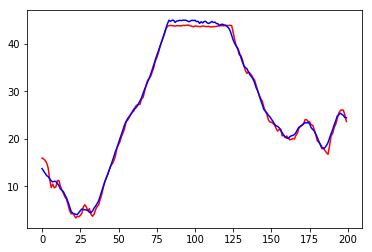

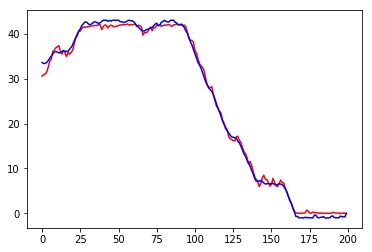

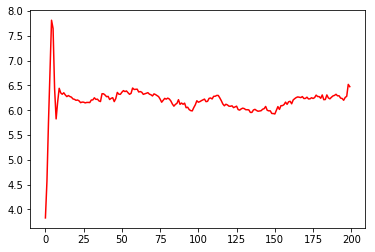

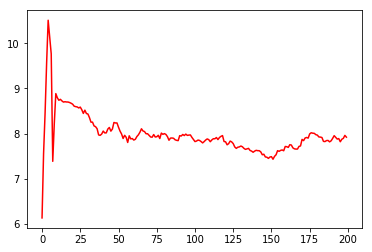

In [15]:
plt.plot(range(seqlen), fmean[:,0], c='r')
plt.plot(range(seqlen), true[:,0], c='b')
plt.show()

plt.plot(range(seqlen), fmean[:,1], c='r')
plt.plot(range(seqlen), true[:,1], c='b')
plt.show()

plt.plot(range(seqlen), fmean[:,2], c='r')
plt.show()

plt.plot(range(seqlen), fmean[:,3], c='r')
plt.show()